In [1]:
# import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import torch
import os
from torch import nn
from torchvision import datasets, transforms
from sklearn.model_selection import train_test_split
import seaborn as sns
from ray import tune

In [86]:
# # old preprocessing steps

# # loop through all files in "data/good_data" and concatenta them into one dataframe
# df = pd.concat([pd.read_csv(f"data/good_data/{file}") for file in os.listdir("data/good_data")])
# # keep only common_name, condition, latitude_coordinate, longitude_coordinate, and native columns
# df = df[['common_name', 'condition', 'latitude_coordinate', 'longitude_coordinate', 'native']]
# # convert condition to numerical
# df['condition'] = df['condition'].replace({'excellent': 4, 'good': 3, 'fair': 2, 'poor': 1, 'dead/dying': 0, 'dead': 0})
# # one hot "common_name" column
# df = pd.get_dummies(df, columns=["common_name"])
# # one hot native column
# df = pd.get_dummies(df, columns=["native"])
# # drop native_no_info column
# df.drop(columns=['native_no_info'], inplace=True)
# # drop rows where condition is null
# df = df.dropna(subset=['condition'])

Raytune?

In [2]:
# import data from processed_data.csv for full set of small_set_processed_data.csv for3 city sample
# df = pd.read_csv('small_set_processed_data.csv')
# df = pd.read_csv('processed_data.csv')
# df = pd.read_csv('ny_processed_data.csv')
df = pd.read_csv('no_species_processed_data.csv')

# split into X and y
X = df.drop('condition', axis=1)
y = df['condition']

# convert from boolean to int
y = y.astype(int)
X = X.astype(float)

# split into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# convert to torch tensors
X_train = torch.tensor(X_train.values)
X_test = torch.tensor(X_test.values)
y_train = torch.tensor(y_train.values)
y_test = torch.tensor(y_test.values)

In [104]:
# print count of each unique value in y_train
print(y_train.unique(return_counts=True))
print(y_test.unique(return_counts=True))

(tensor([0, 1, 2, 3, 4]), tensor([   877,  28809, 115022, 449706,    813]))
(tensor([0, 1, 2, 3, 4]), tensor([   217,   7239,  28952, 112208,    191]))


In [3]:
class NeuralNet(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(NeuralNet, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc2 = nn.ReLU()
        self.fc3 = nn.Linear(hidden_size, num_classes)
    
    def forward(self, x):
        out = self.fc1(x)
        out = self.relu(out)
        out = self.fc2(out)
        out = self.relu(out)
        out = self.fc3(out)
        return out

In [4]:
# parameters
input_size = len(X.columns)
num_classes = len(y.unique())
num_epochs = 100

In [5]:
hidden_size = 500
num_epochs = 100
batch_size = 100
learning_rate = 0.001

# create model
model = NeuralNet(input_size, hidden_size, num_classes)

# loss and optimizer
criterion = nn.CrossEntropyLoss()
# optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

In [6]:
def train_model(model, optimizer, criterion, X_train, y_train, batch_size):
    train_losses = []
    test_losses = []
    train_dataset = torch.utils.data.TensorDataset(X_train, y_train)
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    for epoch in range(num_epochs):
        for batch_X, batch_y in train_loader:
            optimizer.zero_grad()
            outputs = model(batch_X.float())
            loss = criterion(outputs, batch_y)
            loss.backward()
            optimizer.step()
        # calculate train loss
        train_outputs = model(X_train.float())
        train_loss = criterion(train_outputs, y_train)
        train_losses.append(train_loss.item())
        # calculate test loss
        test_outputs = model(X_test.float())
        test_loss = criterion(test_outputs, y_test)
        test_losses.append(test_loss.item())
    return train_losses, test_losses


In [8]:
# train_losses = []
# test_losses = []
# accuracy_list = []
test_predict = []

model = NeuralNet(input_size, hidden_size, num_classes)
# loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
# train model
train_loss, test_loss = train_model(model, optimizer, criterion, X_train, y_train, batch_size)
# keep an array of predictions on test set
test_predictions = model(X.float()).argmax(axis=1)
test_predict.append(test_predictions)
# accuracy = (model(X_test.float()).argmax(axis=1) == y_test).sum().item() / len(y_test)
# accuracy_list.append(accuracy)
# train_losses.append(train_loss)
# test_losses.append(test_loss)


AttributeError: 'DataFrame' object has no attribute 'float'

In [10]:
# save model
torch.save(model.state_dict(), 'trained_model.ckpt')

In [35]:
# import data
test_data = pd.read_csv('no_species_processed_data.csv')
# split into X and y
X = test_data.drop('condition', axis=1)
y = test_data['condition']
# convert from boolean to int
y = y.astype(int)
X = X.astype(float)
# convert to torch tensors
X = torch.tensor(X.values)
y = torch.tensor(y.values)


In [36]:
# load model
model = NeuralNet(input_size, hidden_size, num_classes)
model.load_state_dict(torch.load('trained_model.ckpt'))

<All keys matched successfully>

In [37]:
predict = model(X.float()).argmax(axis=1)
print(predict.shape)

torch.Size([744034])


In [38]:
# save predictions to a csv
predict = pd.DataFrame(predict)
predict.to_csv('all_predictions.csv', index=False)

(tensor([0, 1, 2, 3, 4]), tensor([  1094,  36048, 143974, 561914,   1004]))


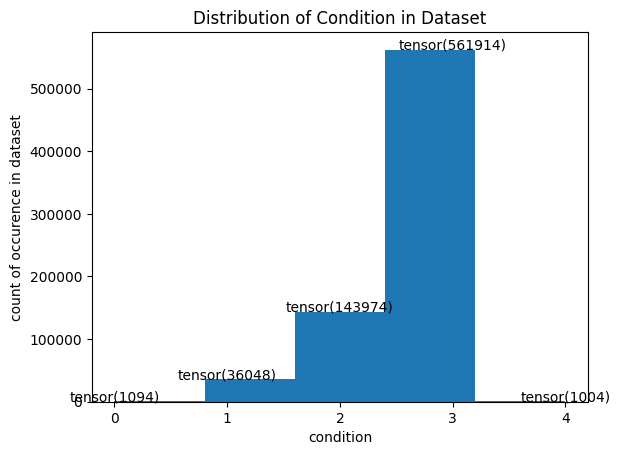

In [45]:
# count each unique value in y
print(y.unique(return_counts=True))
# plot counts of each unique value in y
plt.hist(y, bins=5)
plt.xlabel('condition')
plt.ylabel('count of occurence in dataset')
plt.title('Distribution of Condition in Dataset')
# put value label on column as integer

plt.xticks([0, 1, 2, 3, 4])
plt.show()

In [39]:
# count each occurence of unique value in predictions
print(predict[0].value_counts())


3    654667
2     89367
Name: 0, dtype: int64


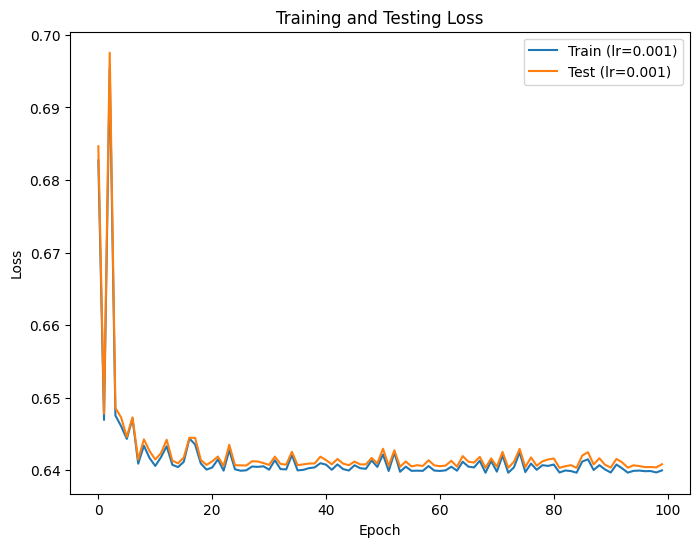

In [110]:
# generate plot
plt.figure(figsize=(8,6))
for i, lr in enumerate(learning_rates):
    plt.plot(train_losses[i], label=f"Train (lr={lr})")
    plt.plot(test_losses[i], label=f"Test (lr={lr})")
plt.title("Training and Testing Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [111]:
# return accuracy of model
def get_accuracy(model, X, y):
    outputs = model(X.float())
    _, predicted = torch.max(outputs.data, 1)
    correct = (predicted == y).sum().item()
    total = y.size(0)
    return correct / total

# get accuracy of model
print(f"Accuracy of model: {get_accuracy(model, X_test, y_test)}")

Accuracy of model: 0.7743452928961675


In [101]:
# copy training and testing data and accuracy to one csv with epochs as index
df = pd.DataFrame()
df['train_loss'] = train_loss
df['test_loss'] = test_loss
df.head()

df_2 = pd.DataFrame()
df_2['accuracy'] = accuracy_list
df_2.head()

# save to csv
df.to_csv('loss.csv')
df_2.to_csv('accuracy.csv')